# San Francisco Lyft Bikeshare Data Analysis

# Summary

The purpose of this analysis was to identify the five most popular commuter trips and develop data-driven offers that could bring in additional customers and revenue. For our analysis, a commuter trip is defined as any trip with different start and end stations during the morning (5 am - 10 am) or early evening (4 pm - 7 pm) lasting less than 1 hour and more than 2 mins. Morning trips are split into two subcategories morning, 5 am - 8 am, and mid-morning, 9 am - 10 am. These choices are supported by trends in the bike-share data.

The top 5 trips during the week are all early evening trips. In order from most popular to least popular, the trips are station 61 to station 50 on Tuesday, station 60 to station 74 on Monday, station 61 to station 50 on Thursday, station 51 to station 70 on Tuesday, and station 61 to station 50 on Wednesday. Also identified were the top 5 trips from station to station regardless of the day. These trips are: 69 - 65, 50 - 61, 61 - 50, 50 - 60,  and 70 - 50. All of the stations that appear in both of these top five queries are located along or near The Embarcadero. 

Two areas were identified as having growth potential. Those are single-use riders (non-subscribers) and weekends. Casual weekend customers tend to ride for longer durations. A tiered incentivization to get customers on bikes during the weekend and then reward them for taking longer rides is proposed below. 

1. Half off Single Trip Unlock fees (Non-subscribers)
2. No Unlock fee if your ride lasts over 45 minutes (All customers)

If a ride lasts over 45 minutes for Non-subscribers they would normally incur two additional 3 dollar charges. This length ride is fairly uncommon for all customers so it is unlikely to have a large impact on profit but may encourage customers to adopt longer weekend ride times that may continue after the promotion ends. With customer volume significantly lower on the weekend, bike availability is not likely to be an issue with incentivizing longer rides. 

Non-subscriber customers make-up a small fraction of all San Francisco bike-share trips. A second incentivization would be geared towards increasing the number of non-subscribers using the San Francisco bike-share. We propose a reoccurring incentive week offered every three months.
- Buy 2 get one free week for non-subscribers

A redemption code for the customer's free third ride would include a link and advertisement to become a subscriber to convert single-ride customers into subscribers. A non-subscribers third ride in one week likely would result in close to or over the monthly price for a member. Not all customers will convert to subscribers but many will take advantage of a potential free ride. 

It is recommended that this offer does not run concurrently with the previously proposed incentive.  Customers can become fatigued with multiple offers and the value of the service diminished if too many price incentives are run at the same time or too close together. 

## Preliminary Data Analysis and Cleaning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import copy

Some quick aggregates of the San Franciso bikes-hare data indicate that the data contains outliers to typical user behavior. The maximum trip length in the raw data is over 4,500 hours with an average of about 17 mins. The standard deviation of the trip data is also very high at 5 hours indicating a very strong skew towards those large duration outliers. 

In [5]:
%%bigquery

SELECT  
    TRUNC(AVG(duration_sec),2) AS AvgTripSec, 
    TRUNC(AVG(duration_sec)/60,2) AS AvgTripMin, 
    TRUNC(STDDEV_SAMP(duration_sec)/60) AS stdev_min,
    TRUNC(STDDEV_SAMP(duration_sec)/3600) AS stdev_hr,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`;

,AvgTripSec,AvgTripMin,stdev_min,stdev_hr
0,1018.93,16.98,306.0,5.0


In [9]:
%%bigquery

SELECT  
    TRUNC(MIN(duration_sec)) AS MinTripSec, 
    TRUNC(MIN(duration_sec)/60,2) AS MinTripMin, 
    TRUNC(MAX(duration_sec)/60) AS MaxTripMin,
    TRUNC(MAX(duration_sec)/3600) AS MaxTripHR,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`;

,MinTripSec,MinTripMin,MaxTripMin,MaxTripHR
0,60.0,1.0,287840.0,4797.0


Looking deeper into the raw data these outliers do not make up a significant portion of the San Francisco bike-share data. Just over twenty-eight thousand of the roughly one million trips or less than 3% are above one hour in duration. Less than one percent of rides are under 2 minutes in duration. Since these trips do not represent typical customer usage they will be removed from the data for this analysis. 

In [62]:
%%bigquery

SELECT 
    COUNT(CASE WHEN duration_sec<60*2 THEN 1 ELSE NULL END) AS Count_Under_2min,
    TRUNC(COUNT(CASE WHEN duration_sec<60*2 THEN 1 ELSE NULL END)/Count(*)*100,2) As Percent_Under_2min,
    COUNT(CASE WHEN duration_sec>60*60 THEN 1 ELSE NULL END) AS Count_Over_1hr,
    TRUNC(COUNT(CASE WHEN duration_sec>60*60 THEN 1 ELSE NULL END)/Count(*)*100,2) AS Percent_Over_1hr,
    COUNT(CASE WHEN start_station_id = end_station_id THEN 1 ELSE NULL END) as Count_start_equal_end,
    TRUNC(COUNT(CASE WHEN start_station_id = end_station_id THEN 1 ELSE NULL END)/Count(*)*100,2) as Percent_start_equal_end
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`; 

,Count_Under_2min,Percent_Under_2min,Count_Over_1hr,Percent_Over_1hr,Count_start_equal_end,Percent_start_equal_end
0,7539,0.76,28091,2.85,32047,3.25


The number of trips increases significantly after the 2-minute mark. Over 17% of all trips last between 2 and 5 minutes. We will leave this data in for our analysis as this may be a valid commute for customers as they travel within the downtown area. A new table, Valid_Trips (see appendix for source SQL), was built with the remaining 929821 trips. This represents about 94.5% of the raw San Francisco bike-share data. Less than 6% of the data has been removed as outliers for our analysis. 

In [19]:
%%bigquery

SELECT 
    COUNT(CASE WHEN duration_sec<60*5 AND duration_sec>60*2 THEN 1 ELSE NULL END) AS Count_Over_2min,
    TRUNC(COUNT(CASE WHEN duration_sec<60*5 AND duration_sec>60*2 THEN 1 ELSE NULL END)/Count(*)*100,2) As Percent_2-5min,
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`; 

,Count_Under_2min,Percent_Under_2min
0,170888,17.37


In [68]:
%%bigquery

SELECT Count(*) as total_valid_trips
    FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips`;

,total_valid_trips
0,929821


After removing these outliers, the remaining San Francisco bike-share data is still skewed towards longer trips with most trips lasting while under an hour in length. However, the standard deviation of the remaining trips is a more reasonable six mins and then the mean has dropped to about 10 mins. 

In [72]:
%%bigquery

SELECT  
    TRUNC(AVG(duration_sec),2) AS avg_trip_sec, 
    TRUNC(AVG(duration_sec)/60,2) AS avg_trip_min, 
    TRUNC(STDDEV_SAMP(duration_sec)) AS stdev_sec,
    TRUNC(STDDEV_SAMP(duration_sec)/60) AS stdev_min,
    FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips`;

,avg_trip_sec,avg_trip_min,stdev_sec,stdev_min
0,585.19,9.75,374.0,6.0


In [73]:
%%bigquery

SELECT  
    TRUNC(MIN(duration_sec)) AS MinTripSec, 
    TRUNC(MIN(duration_sec)/60,2) AS MinTripMin, 
    TRUNC(MAX(duration_sec)/60) AS MaxTripMin,
    TRUNC(MAX(duration_sec)/3600) AS MaxTripHR,
    FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips`;

,MinTripSec,MinTripMin,MaxTripMin,MaxTripHR
0,121.0,2.01,59.0,0.0


The histogram below clearly shows the strong skew still present within the remaining data. There is a clear peak in duration around 10 mins. The number of trips decreases quickly between 10 and 20 minutes and then continues to decrease after 20 minutes. We will continue to refine this data as we complete our data analysis. This will include removing or highlighting data points we determine are trips within the scope of interest, commuter trips. 

In [114]:
%%bigquery times_df

SELECT *
FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips`;

In [115]:
times_df.head(5)

,start_date,dow_int,dow_str,dow_weekday,start_hour,start_hour_str,end_date,start_station_id,end_station_id,duration_sec,duration_min,trip_id
0,2016-02-14 05:25:00+00:00,1,Sunday,Weekend,5,Morning,2016-02-14 05:42:00+00:00,26,83,1021,17.01,1092841
1,2015-10-25 12:45:00+00:00,1,Sunday,Weekend,12,Mid Day,2015-10-25 12:54:00+00:00,24,83,536,8.93,984411
2,2015-10-25 12:45:00+00:00,1,Sunday,Weekend,12,Mid Day,2015-10-25 12:53:00+00:00,24,83,487,8.11,984412
3,2014-10-26 13:11:00+00:00,1,Sunday,Weekend,13,Afternoon,2014-10-26 13:21:00+00:00,11,9,566,9.43,515698
4,2016-06-12 18:15:00+00:00,1,Sunday,Weekend,18,Early Evening,2016-06-12 18:26:00+00:00,11,9,627,10.44,1236584


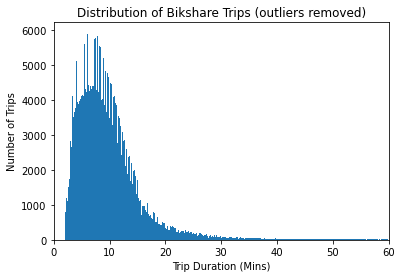

In [98]:
fig, ax = plt.subplots()
ax.hist(times_df.duration_min, bins=1000)
ax.set_xlim(0,60)
ax.set_xlabel("Trip Duration (Mins)")
ax.set_ylabel("Number of Trips")
ax.set_title('Distribution of Bikshare Trip Durations (outliers removed)')

fig.show()

## 5 Most Popular Commuter Trips

The first question of interest we consider is what are the 5 most popular trips that we would call "commuter trips"? A commuter trip will be defined as any weekday trip with different start and end stations during the morning (5 am - 10 am) or early evening (4 pm - 7 pm) lasting less than 1 hour and more than 2 mins. Morning trips are split into two subcategories morning, 5 am - 8 am, and mid-morning, 9 am - 10 am. A SQL query of the Valid_Trips data table supports our selection of commuter time periods. These three time periods are the top three times periods for weekday bike trips. Additionally, weekend trips during these time periods are not as frequent. 

In [106]:
%%bigquery commuter_df

SELECT *
FROM `w205-cuffneylaurie.bike_trip_data.Commuter_Trips`;

In [107]:
commuter_df.head(5)

,start_date,dow_int,dow_str,dow_weekday,start_hour,start_hour_str,end_date,start_station_id,end_station_id,duration_sec,duration_min,trip_id
0,2016-02-14 05:25:00+00:00,1,Sunday,Weekend,5,Morning,2016-02-14 05:42:00+00:00,26,83,1021,17.01,1092841
1,2016-06-12 18:15:00+00:00,1,Sunday,Weekend,18,Early Evening,2016-06-12 18:26:00+00:00,11,9,627,10.44,1236584
2,2013-09-01 18:31:00+00:00,1,Sunday,Weekend,18,Early Evening,2013-09-01 18:43:00+00:00,11,9,769,12.81,8366
3,2015-03-22 10:28:00+00:00,1,Sunday,Weekend,10,Mid Morning,2015-03-22 10:58:00+00:00,11,9,1764,29.39,692379
4,2014-03-16 19:17:00+00:00,1,Sunday,Weekend,19,Early Evening,2014-03-16 19:27:00+00:00,11,9,603,10.05,216131


In [125]:
%%bigquery time_rank_df

SELECT  dow_str AS Day_Of_Week, start_hour_str AS Time_Of_Day,
    Count(trip_id) AS total_trips, RANK() OVER(ORDER BY Count(trip_id) DESC) as rank 
FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips` 
GROUP BY Day_Of_Week, Time_Of_Day;

In [127]:
time_rank_df.head(15)

,Day_Of_Week,Time_Of_Day,total_trips,rank
0,Tuesday,Early Evening,65802,1
1,Wednesday,Early Evening,63498,2
2,Monday,Early Evening,62268,3
3,Thursday,Early Evening,60403,4
4,Friday,Early Evening,51581,5
5,Tuesday,Morning,47492,6
6,Wednesday,Morning,45395,7
7,Thursday,Morning,43527,8
8,Monday,Morning,42441,9
9,Friday,Morning,37101,10


To isolate these commuter trips we will take a subset of the Valid_Trips table, from the previous section. The new table, Commuter_Trips, will include only the aforementioned time periods and trips that begin and end at different stations. Source SQL code for the Commuter_Trips table is available in the appendix. A new variable, trip_stations, to describe the full trip from start station to end stations were added and a view, Commuter_trips_stations, was created to identify the top commuter trips. From this analysis and the previous query, it appears that early evening trips are the most common trips. All but one of the top ten trips during the week are early evening trips. The only exception is a Tuesday morning. 

In [193]:
%%bigquery top_trips_df

SELECT 
    Count(*) AS total_trips,
    trip_stations,
    dow_str, 
    start_hour_str,
    TRUNC(AVG(duration_min),2) AS avg_trip_length_mins,
    MAX(duration_min) AS max_trip_length_mins,
    MIN(duration_min) AS min_trip_length_mins,
FROM `w205-cuffneylaurie.bike_trip_data.Commuter_trips_stations` 
GROUP BY trip_stations, dow_str, start_hour_str
ORDER BY total_trips DESC  


In [117]:
top_trips_df.head(10)

,total_trips,trip_stations,dow_str,start_hour_str,avg_trip_length_mins,max_trip_length_mins,min_trip_length_mins
0,968,61-50,Tuesday,Early Evening,8.00,23.36,5.09
1,936,60-74,Monday,Early Evening,6.70,47.11,3.86
2,903,61-50,Thursday,Early Evening,8.08,27.25,4.90
3,895,51-70,Tuesday,Early Evening,10.22,26.61,5.75
4,895,61-50,Wednesday,Early Evening,7.98,29.14,4.93
5,895,51-70,Wednesday,Early Evening,10.26,31.35,6.16
6,873,60-74,Wednesday,Early Evening,6.71,54.81,3.93
7,870,50-61,Tuesday,Morning,9.42,34.66,5.84
8,868,51-70,Monday,Early Evening,10.12,57.93,6.08
9,859,60-74,Tuesday,Early Evening,6.91,53.96,3.79


Within the top 10 trips, three appear multiple times. These are pairings are station 61 to 50, station 51 to 70, and station 60 to 74. If we look at total full trips between station pairings these three also appear in the top ten. However, the top full trip from station 69 to 65 in this query is not in the top ten of our previous results. All of the stations that appear in both of these top ten queries are located along or near The Embarcadero. 

In [109]:
%%bigquery
SELECT Count(*) AS total, trip_stations
FROM `w205-cuffneylaurie.bike_trip_data.Commuter_trips_stations` 
GROUP BY trip_stations
ORDER BY total DESC 
LIMIT 10

,total,trip_stations
0,6545,69-65
1,5900,50-61
2,5687,61-50
3,5677,50-60
4,5428,70-50
5,5427,60-74
6,5169,74-61
7,5090,65-69
8,5053,51-70
9,4895,70-55


The top 5 trips during the week are early evening trips. In order from most popular to least popular, the trips are station 61 to station 50 on Tuesday, station 60 to station 74 on Monday, station 61 to station 50 on Thursday, station 51 to station 70 on Tuesday, and station 61 to station 50 on Wednesday. The top 5 trips from station to station are: 69 - 65, 50 - 61, 61 - 50, 50 - 60,  and 70 - 50. 

In [120]:
%%bigquery

SELECT *, ST_GEOGPOINT(longitude,latitude) AS loc
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE station_id IN (61, 50, 51, 70, 60, 74, 69, 65, 55);

,station_id,name,latitude,longitude,dockcount,landmark,installation_date,loc
0,60,Embarcadero at Sansome,37.804770,-122.403234,15,San Francisco,2013-08-21,POINT(-122.403234 37.80477)
1,65,Townsend at 7th,37.771058,-122.402717,15,San Francisco,2013-08-22,POINT(-122.402717 37.771058)
2,51,Embarcadero at Folsom,37.791464,-122.391034,19,San Francisco,2013-08-20,POINT(-122.391034 37.791464)
3,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,19,San Francisco,2013-08-23,POINT(-122.39526 37.776617)
4,50,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,23,San Francisco,2013-08-20,POINT(-122.394203 37.795392)
5,55,Temporary Transbay Terminal (Howard at Beale),37.789756,-122.394643,23,San Francisco,2013-08-20,POINT(-122.394643 37.789756)
6,69,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,23,San Francisco,2013-08-23,POINT(-122.39547 37.7766)
7,74,Steuart at Market,37.794139,-122.394434,23,San Francisco,2013-08-25,POINT(-122.394434 37.794139)
8,61,2nd at Townsend,37.780526,-122.390288,27,San Francisco,2013-08-22,POINT(-122.390288 37.780526)


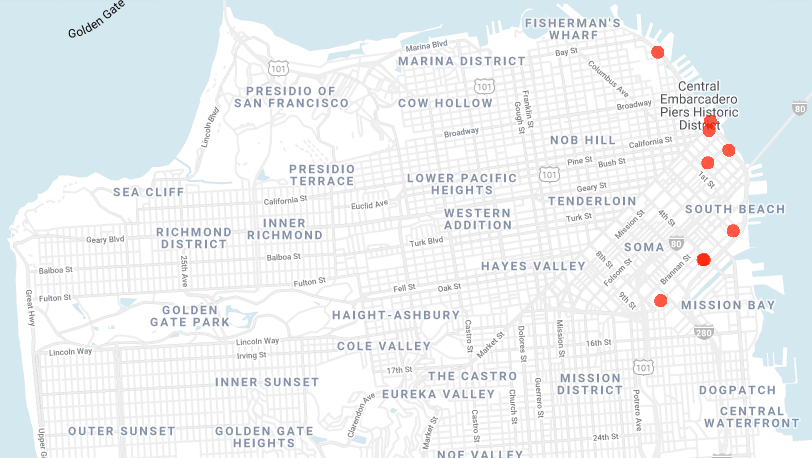

In [122]:
from IPython.display import Image
Image(filename='Images/GeoViz2.PNG',width=800, height=400)

The map above shows the location of the stations used for the most popular commuter trips. 

## Data Driven Recommendations

### Weekend Trends and Customer Types

As seen in the previous section Nightime is the lowest time period for rides. Rides are classified as Nightime trips if they occur between 11 pm and 5 am. We would not recommend incentivizing this time period due to potential liability issues as a result of encouraging bike riding when it is potentially very dark and thus unsafe for customers. 

Almost all weekend time periods are in the bottom 50% of ride frequency, except for Saturday early evening and afternoon which is just above the bottom 50%, as seen in the table below.

In [135]:
time_rank_df[(time_rank_df.Day_Of_Week == 'Saturday') | (time_rank_df.Day_Of_Week =='Sunday')]

,Day_Of_Week,Time_Of_Day,total_trips,rank
20,Saturday,Early Evening,13246,21
21,Saturday,Afternoon,13194,22
26,Sunday,Afternoon,11562,27
27,Sunday,Early Evening,11200,28
30,Saturday,Mid Day,8738,31
33,Sunday,Mid Day,7371,34
35,Saturday,Mid Morning,6194,36
37,Sunday,Mid Morning,5166,38
38,Saturday,Evening,3957,39
39,Saturday,Morning,2992,40


The distribution of trips for each day of the week, over the different time periods, is shown in the figure below. All five weekdays have very similar trends in the data with peaks in the morning and early evening as discussed previously. The Friday data is lower during the peak commuter times established in the previous section. This can be attributed to workers being more inclined to work from home on Fridays. Thus fewer commuters on Friday during peak work commute hours. With a large portion of the workforce not working on the weekends, a dip in weekend use is also expected and is shown in the data. 

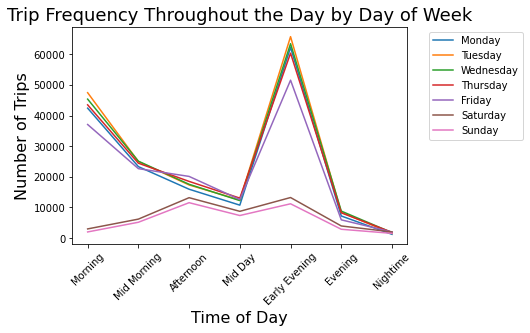

In [189]:
#graph by day morning, midmorning, afternoon, mid day, early evening, evening, nightime
times = {'Morning':1, 'Mid Morning':2, 'Afternoon':3, 'Mid Day':4, 'Early Evening':5, 'Evening':6, 'Nightime':7}
days =['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday']

def dow(df,day):
    dowdf = copy.deepcopy(time_rank_df.loc[time_rank_df.Day_Of_Week == day])
    dowdf['timeday'] = [times[x] for x in dowdf.Time_Of_Day]
    dowdf.sort_values('timeday', inplace = True)
    return dowdf

fig, ax = plt.subplots()

for day in days:
    daydf = dow(time_rank_df,day)
    ax.plot(daydf.timeday,daydf.total_trips)

ax.legend(days,bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xticks(list(times.values()))
ax.set_xticklabels(list(times.keys()))
plt.xticks(rotation='45')
ax.set_title('Trip Frequency Throughout the Day by Day of Week',fontsize=18)
ax.set_ylabel('Number of Trips',fontsize=16)
ax.set_xlabel('Time of Day',fontsize=16)

plt.show()

The weekend, Saturday and Sunday, distributions have peak trip frequencies in the afternoon and early evening and follow similar trends as the weekdays except for the morning and mid-morning hours. However, weekend trip frequencies are significantly lower in almost every time period. The drastically different morning trends for the weekend are likely a result of a large portion of people sleeping in on the weekends. 

Subscribers make up the largest portion of trips throughout the week. Saturday and Sunday are the lowest frequency days for Subscribers. The exact opposite is true for non-subscriber customers. Weekends are the highest frequency days for non-subscriber customers, as seen in the table below. 

In [254]:
%%bigquery cust_freq_df

SELECT
    Count(*) AS total_trips,
    subscriber_type,
    dow_str AS Day_Of_Week,
    TRUNC(AVG(duration_min),2) AS avg_trip_length_mins,
    TRUNC(STDDEV_SAMP(duration_min),2) AS stdev_trip_length_mins,
FROM `w205-cuffneylaurie.bike_trip_data.Trip_wCustomerType` 
GROUP BY subscriber_type, dow_str
ORDER BY total_trips DESC  

In [255]:
cust_freq_df

,total_trips,subscriber_type,Day_Of_Week,avg_trip_length_mins,stdev_trip_length_mins
0,166587,Subscriber,Tuesday,8.70,4.38
1,162604,Subscriber,Wednesday,8.75,4.42
2,157285,Subscriber,Thursday,8.75,4.43
3,151891,Subscriber,Monday,8.71,4.40
4,137137,Subscriber,Friday,8.76,4.48
5,29750,Subscriber,Saturday,9.40,5.58
6,24291,Subscriber,Sunday,9.46,5.72
7,20574,Customer,Saturday,19.68,11.45
8,17427,Customer,Sunday,19.26,11.38
9,14894,Customer,Friday,17.29,10.81


In [251]:
%%bigquery customer_types_df

SELECT
    subscriber_type,
    dow_str AS Day_Of_Week,
    duration_min,
    start_hour_str
FROM `w205-cuffneylaurie.bike_trip_data.Trip_wCustomerType` 

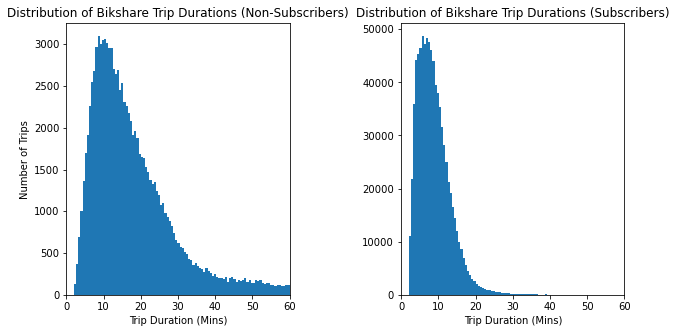

In [277]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(customer_types_df[customer_types_df.subscriber_type=='Customer'].duration_min, bins=100)
ax[0].set_xlim(0,60)
ax[0].set_xlabel("Trip Duration (Mins)")
ax[0].set_ylabel("Number of Trips")
ax[0].set_title('Distribution of Bikshare Trip Durations (Non-Subscribers)')

ax[1].hist(customer_types_df[customer_types_df.subscriber_type=='Subscriber'].duration_min, bins=100)
ax[1].set_xlim(0,60)
ax[1].set_xlabel("Trip Duration (Mins)")
ax[1].set_title('Distribution of Bikshare Trip Durations (Subscribers)')

plt.subplots_adjust(wspace = 0.5)
fig.show()

Non-subscriber customers also tend to ride for longer on average and have a larger variation in their ride times, as shown in the histograms above. Non-subscriber customers are much more likely to ride over 30 minutes than subscribers. Only about 0.14% of subscribers ride over 30 minutes whereas over 6% of non-subscriber customers ride over the 30 minute base time. Non-subscriber customers that over 30 minutes average about a 40-minute ride regardless of the day of the week. At the current price of twenty cents per minute over the base 30 minutes. That 6 percent averages an additional three dollar charge per ride. 

In [245]:
%%bigquery

SELECT
    subscriber_type,
    COUNT(CASE WHEN duration_min>30 THEN 1 ELSE NULL END) AS Count_Over_30min,
    Count(*) As Total,
    TRUNC(COUNT(CASE WHEN duration_min>30 THEN 1 ELSE NULL END)/Count(*)*100/2,2) as Percent_Over_30min
FROM `w205-cuffneylaurie.bike_trip_data.Trip_wCustomerType` 
GROUP BY subscriber_type

,subscriber_type,Count_Over_30min,Total,Percent_Over_30min
0,Subscriber,2412,829545,0.14
1,Customer,12132,100276,6.04


In [249]:
%%bigquery

SELECT
    Count(*) AS total_trips,
    dow_str AS Day_Of_Week,
    TRUNC(AVG(duration_min),2) AS avg_trip_length_mins,
    TRUNC(STDDEV_SAMP(duration_min),2) AS stdev_trip_length_mins
FROM `w205-cuffneylaurie.bike_trip_data.Trip_wCustomerType` 
WHERE subscriber_type = 'Customer' AND duration_min>30
GROUP BY dow_str

,total_trips,Day_Of_Week,avg_trip_length_mins,stdev_trip_length_mins
0,2555,Sunday,40.98,8.48
1,1152,Monday,40.64,8.59
2,1159,Tuesday,40.74,8.30
3,1057,Wednesday,41.47,8.83
4,1285,Thursday,40.46,8.20
5,1760,Friday,40.27,8.40
6,3164,Saturday,40.93,8.51


### Incentives

Since causal weekend customers tend to ride for longer we propose an incentivization for weekend rides. A tiered incentivization to get customers on bikes and then reward them for taking longer rides. 

1. Half off Single Trip Unlock fees (Non-subscribers)
2. No Unlock fee if your ride lasts over 45 minutes (All customers)

If a ride lasts over 45 minutes for Non-subscribers they would normally incur two additional 3 dollar charges. During this promotion, they would receive the second additional fifteen minutes for free. This length ride is fairly uncommon for all customers so it is unlikely to have a large impact on profit but may encourage customers to adopt longer weekend ride times that may continue after the promotion ends. With customer volume significantly lower on the weekend, bike availability is not likely to be an issue with incentivizing longer rides. 

In [237]:
%%bigquery 

SELECT
    COUNT(CASE WHEN subscriber_type='Customer' THEN 1 ELSE NULL END) AS Count_Customer,
    TRUNC(COUNT(CASE WHEN subscriber_type='Customer' THEN 1 ELSE NULL END)/Count(*)*100,2) As Customer
FROM `w205-cuffneylaurie.bike_trip_data.Trip_wCustomerType`

,Count_Customer,Customer
0,100276,10.78


Non-subscriber customers make-up only about eleven percent of all trips. A second incentivization would be geared towards increasing the number of non-subscribers using the San Francisco bike-share. We propose a reoccurring incentive week offered every three months.
- Buy 2 get one free week for non-subscribers

A redemption code for the customer's free third ride would include a link and advertisement to become a subscribe to convert single-ride customers into subscribers. A non-subscribers third ride in one week likely would result in close to or over the monthly price for a member. While not all customers will convert to subscribers many will take advantage of the potential free ride. 

It is recommended that this offer does not run concurrently with the previously proposed incentive.  Customers can be overwhelmed and customer opinion of the service reduced if too many incentives are run at the same time or too close together. 

# Appendix

## BigQuery Tables

Valid_Trips Table

In [ ]:
%%bigquery

SELECT 
start_date,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 4  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
           WHEN EXTRACT(HOUR FROM start_date) >= 5 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 12 THEN "Mid Day"
           WHEN EXTRACT(HOUR FROM start_date) >= 13 and EXTRACT(HOUR FROM start_date) <= 15 THEN "Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 16 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Early Evening"
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
           END AS start_hour_str,
    end_date,
    start_station_id, end_station_id, duration_sec, TRUNC(duration_sec/60,2) AS duration_min, trip_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE start_station_id != end_station_id AND (duration_sec<60*60 AND duration_sec>60*2);

Commuter_Trips

In [ ]:
%%bigquery

SELECT *
FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips` 
WHERE start_station_id != end_station_id and start_hour_str IN ('Early Evening', 'Morning','Mid Morning')

## BigQuery Views

Station_max_min

In [84]:
%%bigquery

SELECT 
        MAX(bikes_available) as max_available, 
        MIN(bikes_available) as min_available, 
        TRUNC(AVG(bikes_available),2) as avg_available,
        dow_str, 
        station_id
FROM `w205-cuffneylaurie.bike_trip_data.status_days` 
GROUP BY station_id, dow_str
ORDER BY station_id, dow_str;

,max_available,min_available,avg_available,dow_str,station_id
0,27,0,12.49,Friday,2
1,27,0,12.74,Monday,2
2,26,0,13.33,Saturday,2
3,27,0,13.13,Sunday,2
4,27,0,12.75,Thursday,2
...,...,...,...,...,...
514,4,2,3.60,Saturday,91
515,3,3,3.00,Sunday,91
516,12,1,5.27,Thursday,91
517,17,2,4.71,Tuesday,91


Commuter_trips_stations

In [ ]:
SELECT  *, CONCAT(start_station_id, '-', end_station_id) AS trip_stations
FROM `w205-cuffneylaurie.bike_trip_data.Commuter_Trips` 

Station_max_min

In [124]:
%%bigquery

SELECT 
        MAX(bikes_available) as max_available, 
        MIN(bikes_available) as min_available, 
        TRUNC(AVG(bikes_available),2) as avg_available,
        dow_str, 
        station_id
FROM `w205-cuffneylaurie.bike_trip_data.status_days` 
GROUP BY station_id, dow_str
ORDER BY station_id, dow_str;

,max_available,min_available,avg_available,dow_str,station_id
0,27,0,12.49,Friday,2
1,27,0,12.74,Monday,2
2,26,0,13.33,Saturday,2
3,27,0,13.13,Sunday,2
4,27,0,12.75,Thursday,2
...,...,...,...,...,...
514,4,2,3.60,Saturday,91
515,3,3,3.00,Sunday,91
516,12,1,5.27,Thursday,91
517,17,2,4.71,Tuesday,91


Trip_wCustomerType

In [ ]:
%%bigquery

SELECT  v.*, c.subscriber_type
FROM `w205-cuffneylaurie.bike_trip_data.Valid_Trips` AS v, `bigquery-public-data.san_francisco.bikeshare_trips` AS c
WHERE v.trip_id = c.trip_id